In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import scipy
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split
import statsmodels.api as sm # import statsmodels 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")
import scipy
import scipy as scipy
import pylab as pylab
import seaborn as sns
from scipy import stats


%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

/Users/Jonathan/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# importing the data 
df = pd.read_csv('Crime_Census_Employment.csv')
#df = pd.read_csv('Crime_Census_Merged_No_Impute_No_Dummies_NEW (2).csv')

As you noticed, we worked with two different datasets (though we commented one out). Both datasets contain both the FBI crime data and census data merged on the Metropolitan Statistical area level (MSA). Our baseline model (linear regression) uses the typical census data (MSA demographics, population, employment, level of education, etc) to predict murder rate, while our enhanced models (Random Forest, Adaboost, OLS) includes more variables such the number of police available in the MSA, the number of mental health workers, the average salary per hour for police and that of mental health workers. We also attempted to include gun ownership/sales for each MSA, but we couldn't find the right data. We believe that adding these variables to the census data should improve our model performance. 

In [144]:
df.head()

,Unnamed: 0,msa_name,msa_id,year,tot_pop,rep_violent_crime,rep_murder,rep_rape,rep_robbery,rep_agg_assault,rep_pro_crime,rep_burglary,rep_theft,rep_veh_theft,All families - Percent below poverty level; Families,All families - Total; Families,Below poverty level; 18 to 64 years,Below poverty level; 65 years and over,Below poverty level; Under 18 years,Below poverty level; EDUCATIONAL ATTAINMENT - Population 25 years and over,Below poverty level; EMPLOYMENT STATUS - Civilian labor force 16 years and over,Below poverty level; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,Below poverty level; Female,Below poverty level; Male,Below poverty level; Unrelated individuals for whom poverty status is determined,Below poverty level; WORK EXPERIENCE - Population 16 years and over,Divorced; LABOR FORCE PARTICIPATION - Males 16 years and over,Divorced; Population 15 years and over,Employed; 16 to 19 years,Employed; 20 to 24 years,Employed; 25 to 44 years,Employed; 45 to 54 years,Employed; 55 to 64 years,Employed; 65 to 74 years,Employed; 75 years and over,Employed; EDUCATIONAL ATTAINMENT - Population 25 to 64 years,Employed; Population 16 years and over,Employed; Population 20 to 64 years,Employed; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,"Female householder, no husband present - Percent below poverty level; Families","Female householder, no husband present - Total; Families",Female; 10 to 14 years,Female; 15 to 19 years,Female; 20 to 24 years,Female; 25 to 29 years,Female; 30 to 34 years,Female; 35 to 39 years,Female; 40 to 44 years,Female; 45 to 49 years,Female; 5 to 9 years,...,Total; Population 18 to 24 years_y,Total; Population 20 to 64 years,Total; Population 25 years and over,Total; Population 3 years and over enrolled in school,Total; Population 35 to 44 years,Total; Population 45 to 64 years,Total; Population 65 years and over,Total; Age dependency ratio,Total; Median age (years),Total; Sex ratio (males per 100 females),Total; Total population,Total; Did not work,Total; Worked 1 to 13 weeks,Total; Worked 14 to 26 weeks,Total; Worked 27 to 39 weeks,Total; Worked 40 to 49 weeks,Total; Worked 50 to 52 weeks,Total; WORK EXPERIENCE - Population 16 years and over,Total; WORK STATUS - Families,Unemployment rate; 16 to 19 years,Unemployment rate; 20 to 24 years,Unemployment rate; 25 to 44 years,Unemployment rate; 45 to 54 years,Unemployment rate; 55 to 64 years,Unemployment rate; 65 to 74 years,Unemployment rate; 75 years and over,Unemployment rate; EDUCATIONAL ATTAINMENT - Population 25 to 64 years,Unemployment rate; Population 16 years and over,Unemployment rate; Population 20 to 64 years,Unemployment rate; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,Veterans; 18 to 34 years,Veterans; 35 to 54 years,Veterans; 55 to 64 years,Veterans; 65 to 74 years,Veterans; 75 years and over,Veterans; Civilian population 18 years and over,Veterans; EDUCATIONAL ATTAINMENT,Veterans; EMPLOYMENT STATUS,Veterans; PERIOD OF SERVICE - Korean War veterans,Veterans; PERIOD OF SERVICE - Vietnam era veterans,Veterans; PERIOD OF SERVICE - World War II veterans,Veterans; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,Veterans; Female,Veterans; Male,Widowed; LABOR FORCE PARTICIPATION - Males 16 years and over,Widowed; Population 15 years and over,hourly_wage_mental_health,hourly_wage_police,total_emp_mental_health,total_emp_police
0,0,"Abilene, TX",10180.0,2016.0,169885.0,614.0,11.0,79.0,137.0,387.0,4932.0,1104.0,530.0,298.0,10.9,38610.0,16605.0,2599.0,7690.0,15034.0,7682.0,21007.0,14320.0,12574.0,12746.0,19989.0,9.3,10.9,28.6,59.6,NaN,67.6,NaN,27.9,7.4,65.5,52.9,64.6,54.7,29.7,7677.0,7.0,7.0,8.2,7.3,6.8,6.0,4.5,5.0,6.8,...,21091.0,98190.0,109703.0,44265.0,18904.0,38498.0,26080.0,63.2,34.4,104.9,170860.0,31639.0,5639.0,3844.0,3640.0,NaN,60767.0,121346.0,38610.0,10.4,3.3,NaN,2.3,NaN,5.3,0.0,3.5,3.9,3.5,4.0,2226.0,3041.0,2624.0,3326.0,2388.0,13605.0,13583.0,7891.0,867.0,4712.0,449.0,11897.0,740.0,12865.0,2.5,5.5,18.71,27.41,90.0,400

# Data Cleaning

In [3]:
#creating a murder rate variable
df["murder_rate"] = df["rep_murder"]*100000/df["tot_pop"]

In [4]:
# size of the dataset
df.shape

(2697, 295)

In [5]:
# creating dummy variables for each metropolitan statistical area (MSA)

dummy_fields = ['msa_name']
for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df, dummies], axis=1)

In [6]:
# drop all columns with more than 10% data missing 
df = df.loc[:, pd.notnull(df).sum()>len(df)*.9]
df.shape

(2697, 629)

After merging around 280+ census data variables with 8 FBI crime data variables, and after creating a dummy variable for every MSA, we end up with 629 variables in total. Since we have about 2700 observations which is 4 times bigger than the number of variables, we won't run into a dimensionality problem and therefore don't see a need to reduce the number of variables right away. 

In [7]:
# print out the colums with more than 30 values (1% of the data) missing
for column in df.columns:
    if df[column].isnull().sum() > 30:
        print(column)
#df.isnull().sum()

rep_violent_crime
rep_rape
rep_agg_assault
rep_pro_crime
rep_burglary
rep_theft
Households not receiving food stamps; WORK STATUS - Families
Households receiving food stamps; WORK STATUS - Families
Mean income (dollars); per capita income Asian
Mean income (dollars); per capita income Black or African American
Mean income (dollars); per capita income Two or more races
Total; WORK STATUS - Families
Veterans; PERIOD OF SERVICE - Korean War veterans
Veterans; PERIOD OF SERVICE - Vietnam era veterans
Veterans; PERIOD OF SERVICE - World War II veterans


In [8]:
# missing values
#df.isnull().sum()

In [9]:
# columns with more than 50 missing values
for column in df.columns:
    if df[column].isnull().sum() > 50:
        print(column)

rep_violent_crime
rep_pro_crime
Households not receiving food stamps; WORK STATUS - Families
Households receiving food stamps; WORK STATUS - Families
Mean income (dollars); per capita income Asian
Mean income (dollars); per capita income Black or African American
Mean income (dollars); per capita income Two or more races
Total; WORK STATUS - Families
Veterans; PERIOD OF SERVICE - Korean War veterans
Veterans; PERIOD OF SERVICE - Vietnam era veterans
Veterans; PERIOD OF SERVICE - World War II veterans


In [10]:
# drop every row in which more than a 100 variables have missing values
df = df.dropna(thresh=100)

In [153]:
df[:10]

,Unnamed: 0,msa_name,msa_id,year,tot_pop,rep_violent_crime,rep_murder,rep_rape,rep_robbery,rep_agg_assault,rep_pro_crime,rep_burglary,rep_theft,rep_veh_theft,Below poverty level; 18 to 64 years,Below poverty level; 65 years and over,Below poverty level; Under 18 years,Below poverty level; EDUCATIONAL ATTAINMENT - Population 25 years and over,Below poverty level; EMPLOYMENT STATUS - Civilian labor force 16 years and over,Below poverty level; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,Below poverty level; Female,Below poverty level; Male,Below poverty level; Unrelated individuals for whom poverty status is determined,Below poverty level; WORK EXPERIENCE - Population 16 years and over,Divorced; LABOR FORCE PARTICIPATION - Males 16 years and over,Employed; 16 to 19 years,Employed; 20 to 24 years,Employed; 45 to 54 years,Employed; 65 to 74 years,Employed; 75 years and over,Employed; EDUCATIONAL ATTAINMENT - Population 25 to 64 years,Employed; Population 16 years and over,Employed; Population 20 to 64 years,Employed; RACE AND HISPANIC OR LATINO ORIGIN - One race - White,Female; 10 to 14 years,Female; 15 to 19 years,Female; 20 to 24 years,Female; 25 to 29 years,Female; 30 to 34 years,Female; 35 to 39 years,Female; 40 to 44 years,Female; 45 to 49 years,Female; 5 to 9 years,Female; 50 to 54 years,Female; 55 to 59 years,Female; 60 to 64 years,Female; 65 to 69 years,Female; 70 to 74 years,Female; 75 to 79 years,Female; 80 to 84 years,...,"msa_name_Spokane, WA","msa_name_Spokane-Spokane Valley, WA","msa_name_Springfield, IL","msa_name_Springfield, MO","msa_name_Springfield, OH","msa_name_St. Cloud, MN","msa_name_St. George, UT","msa_name_St. Joseph, MO-KS","msa_name_St. Louis, MO-IL","msa_name_State College, PA","msa_name_Staunton-Waynesboro, VA","msa_name_Stockton, CA","msa_name_Stockton-Lodi, CA","msa_name_Sumter, SC","msa_name_Syracuse, NY","msa_name_Tallahassee, FL","msa_name_Tampa-St. Petersburg-Clearwater, FL","msa_name_Texarkana, TX-AR","msa_name_Texarkana, TX-Texarkana, AR","msa_name_Toledo, OH","msa_name_Topeka, KS","msa_name_Trenton, NJ","msa_name_Trenton-Ewing, NJ","msa_name_Tucson, AZ","msa_name_Tulsa, OK","msa_name_Tuscaloosa, AL","msa_name_Tyler, TX","msa_name_Urban Honolulu, HI","msa_name_Utica-Rome, NY","msa_name_Vallejo-Fairfield, CA","msa_name_Victoria, TX","msa_name_Vineland-Bridgeton, NJ","msa_name_Vineland-Millville-Bridgeton, NJ","msa_name_Virginia Beach-Norfolk-Newport News, VA-NC","msa_name_Visalia-Porterville, CA","msa_name_Waco, TX","msa_name_Washington-Arlington-Alexandria, DC-VA-MD-WV","msa_name_Waterloo-Cedar Falls, IA","msa_name_Wausau, WI","msa_name_Weirton-Steubenville, WV-OH","msa_name_Wheeling, WV-OH","msa_name_Wichita, KS","msa_name_Williamsport, PA","msa_name_Wilmington, NC","msa_name_Winchester, VA-WV","msa_name_Winston-Salem, NC","msa_name_Yakima, WA","msa_name_York-Hanover, PA","msa_name_Youngstown-Warren-Boardman, OH-PA","msa_name_Yuba City, CA"
0,0,"Abilene, TX",10180.0,2016.0,169885.0,614.0,11.0,79.0,137.0,387.0,4932.0,1104.0,530.0,298.0,16605.0,2599.0,7690.0,15034.0,7682.0,21007.0,14320.0,12574.0,12746.0,19989.0,9.3,28.6,59.6,67.6,27.9,7.4,65.5,52.9,64.6,54.7,7.0,7.0,8.2,7.3,6.8,6.0,4.5,5.0,6.8,6.1,5.0,6.5,5.9,3.5,3.0,2.6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,"Abilene, TX",10180.0,2015.0,169713.0,700.0,9.0,95.0,133.0,463.0,6125.0,1446.0,232.0,447.0,13275.0,1718.0,6658.0,11047.0,7066.0,14496.0,12397.0,9254.0,9716.0,15476.0,11.9,31.5,59.2,72.2,26.6,6.8,67.2,54.5,65.8,55.2,6.4,7.5,9.3,7.1,5.9,5.3,5.7,5.2,6.4,6.4,6.8,5.4,4.2,4.2,1.8,3.6,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,"Abilene, TX",10180.0,2014.0,169202.0,677.0,10.0,113.0,140.0,414.0,6207.0,1428.0,372.0,407.0,14860.0,2855.0,7733.0,13219.0,8777.0,16691.0,15021.0,10427.0,8570.0,18526.0,12.7,37.8,67.8,72.2,28.6,9.6,66.2,55.7,66.4,56.5,6.6,6.3,9.1,7.2,6.5,5.3,5.1,5.3,6.6,7.4,5.9,5.5,4.8,4.0,3.5,1.9,.

In [154]:
#df.isnull().sum()
#df.columns

In [11]:
df = df.drop(["Unnamed: 0",'msa_id', "rep_rape", "rep_murder", "rep_robbery", "rep_agg_assault", 
              "rep_pro_crime", "rep_burglary", "rep_theft", "rep_veh_theft", "rep_violent_crime"], axis=1)

We removed all crime variables other than our depedent variable (murder rate) because we believe these variables are highly correlated with our dependent variable. We also often don't have access to this data until the end of the year.

Our approach is to try and forecast future crime based on past crime. We used the data from 2006 to 2015 to predict crime in 2016. 

In [15]:
#train on previous years and test on 2016

train_2016 = df[df.year < 2016]
test_2016 = df[df.year == 2016]
train_2015 = df[df.year < 2015]
test_2015 = df[df.year == 2015]
train_2014 = df[df.year < 2014]
test_2014 = df[df.year == 2014]

In [17]:
# mean-impute all missing values (these are actually a few variables since we already cleaned most of the dataset)
for column in train.columns:
    if df[column].isnull().sum() > 0:
        train.loc[:,column] = train.fillna(train.mean()[column])
        test.loc[:,column] = test.fillna(train.mean()[column])

In [18]:
# Split into features and targets
X_train, y_train = train.drop('murder_rate', axis=1), train['murder_rate']
X_test, y_test = test.drop('murder_rate', axis=1), test['murder_rate']

In [19]:
# A sanity check to make sure our target variable is not in the training data
"murder_rate" in X_train.columns

False

# Model building and Evaluation

In [59]:
# our baseline model 

LR = LinearRegression()

LR.fit(X_train, y_train)
LR_predictions = LR.predict(X_test)
score = mean_absolute_error(y_test, LR_predictions)
print("Linear Regression Absolute Mean Error: %.4f" % score)
print("R-Squared Score:", r2_score(y_test, LR_predictions))

Linear Regression Absolute Mean Error: 1.7003
R-Squared Score: 0.483652109014


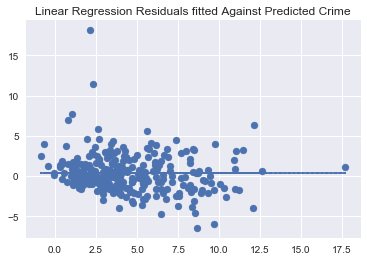

In [60]:
residuals = y_test - LR_predictions

plt.scatter(LR_predictions, residuals)
y_mean = [np.mean(residuals)]*len(LR_predictions)
plt.plot(LR_predictions, y_mean, label='Mean', linestyle='--')
plt.title("Linear Regression Residuals fitted Against Predicted Crime")

Our baseline model above (Linear Regression) has a R-squared score of 0.48, using our model on
the data explains 48% of the variance in the dependent variable. From the residuals plot, we can also see that this is the best our linear regression can do: the residuals are relatively stochastic. Our next step is to use more advanced models, specifically, tree based models. These models are known to work well with high dimensional data with a mix of categorical and continuous variables. These models also allow us to tune different parameters (number of estimators, etc) to maximize the performance.

We try 2 different models: Random Forest, Adaboost

In [28]:
train_2014 = df[df.year < 2014]
test_2014 = df[df.year == 2014]
train = train_2014.drop(['msa_name'], axis = 1)
test = test_2014.drop(['msa_name'], axis = 1)
for column in train.columns:
    if df[column].isnull().sum() > 0:
        train.loc[:,column] = train.fillna(train.mean()[column])
        test.loc[:,column] = test.fillna(train.mean()[column])

# Split into features and targets
X_train, y_train = train.drop('murder_rate', axis=1), train['murder_rate']
X_test, y_test = test.drop('murder_rate', axis=1), test['murder_rate']

# our baseline model 

LR = LinearRegression()

LR.fit(X_train, y_train)
LR_predictions = LR.predict(X_test)
score = mean_absolute_error(y_test, LR_predictions)
print("Linear Regression Absolute Mean Error (2014): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, LR_predictions))


#training random forest
RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

RF.fit(X_train, y_train)
# training and testing Adaboost
ABR = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None), n_estimators= 200, learning_rate=.01)
ABR.fit(X_train, y_train)

# Training and testing OLS to evaluate significant variables. 
X_train_OLS = sm.add_constant(X_train) ## let's add an intercept (beta_0) to our model
model = sm.OLS(y_train, X_train_OLS).fit() ## sm.OLS(output, input)
#predictions = model.predict(X_train_OLS)
results = model.summary()


RF_predictions = RF.predict(X_test)
score = mean_absolute_error(y_test, RF_predictions)
print("Random Forest Mean Absolute Error (2014): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, RF_predictions))
# Testing Adaboost 
ABR_predictions = ABR.predict(X_test)
score = mean_absolute_error(y_test, ABR_predictions)
print("Adaboost Regressor Mean Absolute Error (2014): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, ABR_predictions))
#X_test_OLS = sm.add_constant(X_test)
#predictions = model.predict(X_test_OLS)
#print("OLS Mean Absolute Error (2015): %.4f" % score)
#print("R-Squared Score:", r2_score(y_test, predictions))

y_test.mean()
print("Average Murder Rate 2014:", y_test.mean())

Linear Regression Absolute Mean Error (2014): 1.4938
R-Squared Score: 0.456812400115
Random Forest Mean Absolute Error (2014): 1.4053
R-Squared Score: 0.556422049571
Adaboost Regressor Mean Absolute Error (2014): 1.3905
R-Squared Score: 0.52175847607
Average Murder Rate 2014: 4.261092611976465


In [33]:
train_2016 = df[df.year < 2016]
test_2016 = df[df.year == 2016]
train = train_2016.drop(['msa_name'], axis = 1)
test = test_2016.drop(['msa_name'], axis = 1)
for column in train.columns:
    if df[column].isnull().sum() > 0:
        train.loc[:,column] = train.fillna(train.mean()[column])
        test.loc[:,column] = test.fillna(train.mean()[column])

# Split into features and targets
X_train, y_train = train.drop('murder_rate', axis=1), train['murder_rate']
X_test, y_test = test.drop('murder_rate', axis=1), test['murder_rate']

# our baseline model 

LR = LinearRegression()

LR.fit(X_train, y_train)
LR_predictions = LR.predict(X_test)
score = mean_absolute_error(y_test, LR_predictions)
print("Linear Regression Absolute Mean Error (2016): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, LR_predictions))


#training random forest
RF = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

RF.fit(X_train, y_train)
# training and testing Adaboost
ABR = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None), n_estimators= 200, learning_rate=.01)
ABR.fit(X_train, y_train)

# Training and testing OLS to evaluate significant variables. 
X_train_OLS = sm.add_constant(X_train) ## let's add an intercept (beta_0) to our model
model = sm.OLS(y_train, X_train_OLS).fit() ## sm.OLS(output, input)
#predictions = model.predict(X_train_OLS)
results = model.summary()


RF_predictions = RF.predict(X_test)
score = mean_absolute_error(y_test, RF_predictions)
print("Random Forest Mean Absolute Error (2016): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, RF_predictions))
# Testing Adaboost 
ABR_predictions = ABR.predict(X_test)
score = mean_absolute_error(y_test, ABR_predictions)
print("Adaboost Regressor Mean Absolute Error (2016): %.4f" % score)
print("R-Squared Score:", r2_score(y_test, ABR_predictions))
#X_test_OLS = sm.add_constant(X_test)
#predictions = model.predict(X_test_OLS)
#print("OLS Mean Absolute Error (2015): %.4f" % score)
#print("R-Squared Score:", r2_score(y_test, predictions))

y_test.mean()
print("Average Murder Rate 2016:", y_test.mean())

Linear Regression Absolute Mean Error (2016): 1.7003
R-Squared Score: 0.483652109014
Random Forest Mean Absolute Error (2016): 1.6609
R-Squared Score: 0.545625835331
Adaboost Regressor Mean Absolute Error (2016): 1.6795
R-Squared Score: 0.501548161123
Average Murder Rate 2016: 4.873303063571736


Random Forest with a 1000 trees, using the larger dataset, has the best performance of all the models we use (including the baseline model) on R-squared score and on mean absolute value. This is consistent for both 2014 and 2016. For 2016, Random Forest is able to explain 54% variance in the dependent variable and can predict the rate within 1.65 above or below the actual murder rate on average. Note that the average  murder for 2016 is 4.87. 

# Residual Analysis 

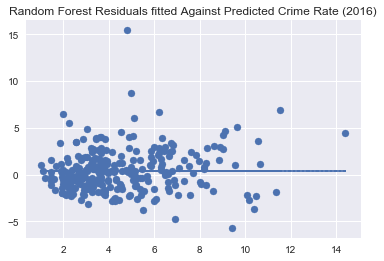

In [38]:
# Random Forest 
residuals = y_test - RF_predictions
plt.scatter(RF_predictions, residuals)
y_mean = [np.mean(residuals)]*len(RF_predictions)
plt.plot(RF_predictions, y_mean, label='Mean', linestyle='--')
plt.title("Random Forest Residuals fitted Against Predicted Crime Rate (2016)")

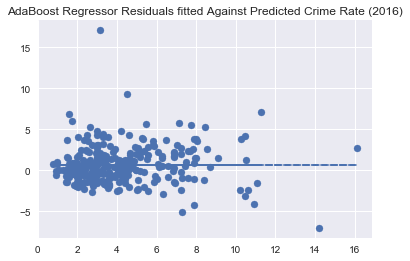

In [39]:
# Adaboost 
residuals = y_test - ABR_predictions
plt.scatter(ABR_predictions, residuals)
y_mean = [np.mean(residuals)]*len(ABR_predictions)
plt.plot(ABR_predictions, y_mean, label='Mean', linestyle='--')
plt.title("AdaBoost Regressor Residuals fitted Against Predicted Crime Rate (2016)")

# Lift curves analysis 

In [41]:
# a function to calculate the gini score 

# code from http://markeyser.com/
def gini(actual,pred,weight):
    pdf= pd.DataFrame(scipy.vstack([actual,pred, weight]).T,columns=['Actual','Predicted', "Weight"],)
    pdf= pdf.sort_values('Predicted')
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    return Gini

In [42]:
# a function to plot the lift curves 

def lift(actual, pred, weight,n=10,xlab='Predicted Decile',MyTitle='Model Performance Lift Chart'):
    pdf= pd.DataFrame(scipy.vstack([actual,pred, weight]).T,columns=['Actual','Predicted', "Weight"],)
    pdf = pdf.sort_values(by = ['Predicted', "Actual", "Weight"])
    pdf['CummulativeWeight'] = np.cumsum(pdf['Weight'])
    pdf['CummulativeWeightedActual'] = np.cumsum(pdf['Actual']*pdf['Weight'])
    TotalWeight = sum(pdf['Weight'])
    
    Numerator = sum(pdf['CummulativeWeightedActual']*pdf['Weight'])
    Denominator = sum(pdf['Actual']*pdf['Weight']*TotalWeight)
    Gini = 1.0 - 2.0 * Numerator/Denominator
    NormalizedGini = Gini/ gini(pdf['Actual'],pdf['Actual'], pdf["Weight"])
    GiniTitle = 'Normalized Gini = '+ str(round(NormalizedGini,4))
    
    pdf['PredictedDecile'] = np.round(pdf['CummulativeWeight']*n /TotalWeight + 0.5,decimals=0)
    pdf['PredictedDecile'][pdf['PredictedDecile'] < 1.0] = 1.0
    pdf['PredictedDecile'][pdf['PredictedDecile'] > n] = n 

    pdf['WeightedPrediction'] = pdf['Predicted']*pdf['Weight']
    pdf['WeightedActual'] = pdf['Actual']*pdf['Weight']
    lift_df = pdf.groupby('PredictedDecile').agg({'WeightedPrediction': np.sum,'Weight':np.sum,'WeightedActual':np.sum,'PredictedDecile':np.size})
    #nms = lift_df.columns.values
    #nms[1] = 'Count'
    #lift_df.columns = nms
    lift_df['AveragePrediction'] = lift_df['WeightedPrediction']/lift_df['Weight']
    lift_df['AverageActual'] = lift_df['WeightedActual']/lift_df['Weight']
    lift_df['AverageError'] = lift_df['AverageActual']/lift_df['AveragePrediction']

    d = pd.DataFrame(lift_df.index)
    p = lift_df['AveragePrediction']
    a = lift_df['AverageActual']
    pylab.plot(d,p,label='Predicted',color='blue',marker='o')
    pylab.plot(d,a,label='Actual',color='red',marker='d')
    pylab.legend(['Predicted','Actual'], loc=2)
    pylab.title(MyTitle +'\n'+GiniTitle)
    pylab.xlabel(xlab)
    pylab.ylabel('Actual vs. Predicted')
    pylab.grid()
    pylab.show()

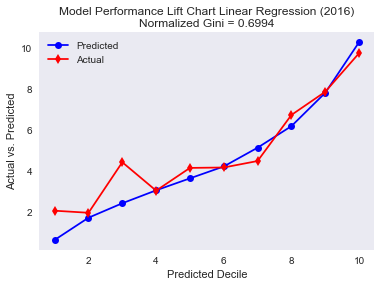

In [61]:
# Linear Regression Regressor Lift Curve
weight = [1.0] * len(y_test)
lift(y_test, LR_predictions, weight,n=10,xlab='Predicted Decile',\
       MyTitle='Model Performance Lift Chart Linear Regression (2016)')

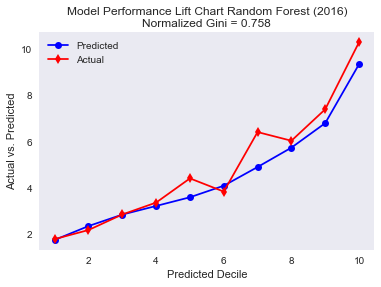

In [62]:
# Random Forest Regressor Lift Curve
weight = [1.0] * len(y_test)
lift(y_test, RF_predictions, weight,n=10,xlab='Predicted Decile',\
       MyTitle='Model Performance Lift Chart Random Forest (2016)')

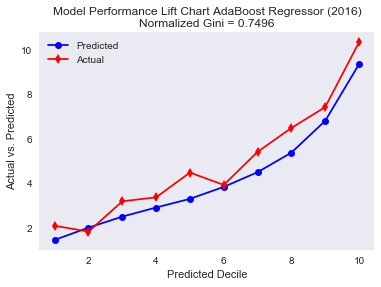

In [63]:
# Adaboost Regressor Lift Curve
weight = [1.0] * len(y_test)
lift(y_test, ABR_predictions, weight,n=10,xlab='Predicted Decile',\
       MyTitle='Model Performance Lift Chart AdaBoost Regressor (2016)')

The above lift curves show how well we're predicting smaller values vs larger values in the test dataset. With linear regression, we are doing much better predicting for MSAs with large murder rates but not as well for those small murder rates. With random forest, we are doing better for those with with MSAs with small rates and those with large states, but not as well for those in the middle (two points in the graph are off from the actual). AdaBoost does better than the baseline model but not as well as Random Forest. 

# Identifying Important Variables

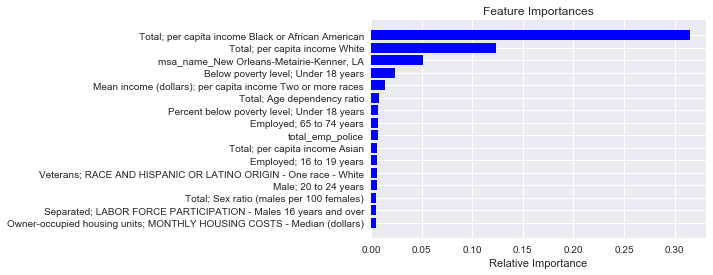

In [58]:
# Feature importance from random Forest 
features = X_train.columns
importances = RF.feature_importances_
indices = np.argsort(importances)
plt.title("Feature Importances")
plt.barh(range(len(indices[600:])), importances[indices[600:]], color='b', align='center')
plt.yticks(range(len(indices[600:])), features[indices[600:]]) ## removed [indices]
plt.xlabel('Relative Importance')
plt.show()

In [65]:
test_msa = df.msa_name[df.year == 2016]

In [66]:
# Our final dataset of actual vs predicted 

final_msa_data = pd.DataFrame()

final_msa_data["test_msa"] = test_msa
final_msa_data["murder_rate"] = y_test
final_msa_data["predicted_murder_rate"] = RF_predictions

In [67]:
#final predictions for 2016

final_msa_data[:20]

,test_msa,murder_rate,predicted_murder_rate
0,"Abilene, TX",6.474968,3.881602
16,"Akron, OH",5.827498,4.566303
18,"Albany-Schenectady-Troy, NY",2.049726,3.324864
27,"Albany, GA",11.798173,8.900783
36,"Albuquerque, NM",8.267743,6.172508
46,"Alexandria, LA",7.790589,7.081599
62,"Allentown-Bethlehem-Easton, PA-NJ",2.644962,3.523275
63,"Altoona, PA",0.800371,2.844256
82,"Amarillo, TX",5.318684,4.247342
83,"Anchorage, AK",8.870837,4.882286
